In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras_retinanet

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Generate RetinaNet model

In [2]:
image = keras.layers.Input((None, None, 3))
model = keras_retinanet.models.ResNet50RetinaNet(image, num_classes=90, weights='imagenet')

# compile model
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.regression_loss,
        'classification': keras_retinanet.losses.focal_loss()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)
#print(model.summary())

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.


## Initialize data generators

In [3]:
# create image data generator objects
train_image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
)
test_image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
)

# create a generator for training data
train_generator = keras_retinanet.preprocessing.coco.CocoIterator(
    '/srv/datasets/COCO',
    'train2017',
    train_image_data_generator,
)

# create a generator for testing data
test_generator = keras_retinanet.preprocessing.coco.CocoIterator(
    '/srv/datasets/COCO',
    'val2017',
    test_image_data_generator,
)

loading annotations into memory...
Done (t=15.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


## Train on data

In [ ]:
batch_size = 1 # batch_size > 1 is not yet supported
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator.image_ids) // batch_size,
    epochs=20,
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator.image_ids) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint('snapshots/resnet50_coco_best.h5', monitor='val_loss', verbose=1, save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0),
    ],
)

## Run detection on example

processing time:  0.04982471466064453


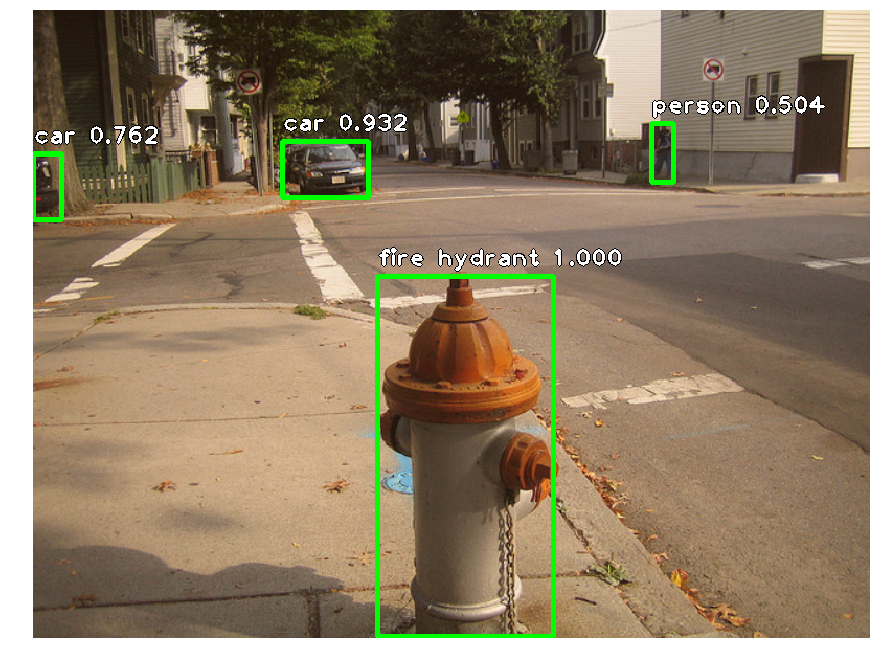

In [14]:
image_batch, outputs = next(test_generator)
image = image_batch[0, ...].copy()
image -= min(image.flatten())
image /= max(image.flatten())
image *= 255
image = image.astype(np.uint8)

start = time.time()
_, _, detections = model.predict_on_batch(image_batch)
print("processing time: ", time.time() - start)

im = image.copy()
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = np.max(detections[0, :, 4:], axis=1)

for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue

    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 3)
    caption = "{} {:.3f}".format(test_generator.labels[label], score)
    cv2.putText(im, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(im, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(im)
plt.show()